##Access GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c558ea60-4aa9-58a3-49b0-664865099c47)


##Get the data
link -https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
#check files in pubmed_2ok dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/




dev.txt  test.txt  train.txt


In [4]:
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
#check the filnames
import os
filenames =[data_dir+ filename for filename in os.listdir(data_dir)]
filenames


['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

##Visualaized the Data

In [6]:
#function to read the text files
def get_lines(filename):
  """
  read filename a  text file and returns the lines of text as list

  Args :
  filename : a string concatanation a target filepath

  Returns :
  a list of strigs with one strig per line from target fielname
  """

  with open(filename,"r") as f:
    return f.readlines()


In [7]:
#read the training lines
train_lines =get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:

def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [10]:
#get data from file and preprocess it
%%time
train_samples =preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples =preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples =preprocess_text_with_line_numbers(data_dir+"test.txt")

print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 456 ms, sys: 87.1 ms, total: 543 ms
Wall time: 544 ms


In [11]:
#check sample data
train_samples[:15]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [12]:
import pandas as pd
train_df =pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head(14)



,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
#distibution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

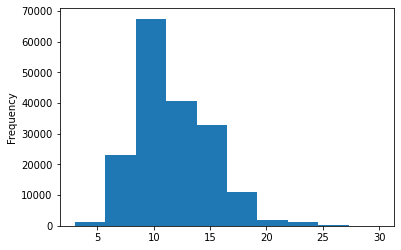

In [14]:
#check the length of different lines
train_df.total_lines.plot.hist()


##Get the list of Sentences

In [15]:
#convert abastarct text lines into text
train_sentences=train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()
print(len(train_sentences),len(val_sentences),len(test_sentences))

180040 30212 30135


In [16]:
#view the the lines
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

##Make numeric labels

In [17]:
#one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder =OneHotEncoder(sparse=False)

In [18]:
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
val_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
test_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

##Label encode Labels

In [21]:
#extract labels
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_label_encoded =label_encoder.fit_transform(train_df["target"].to_numpy())
val_label_encoded =label_encoder.fit_transform(val_df["target"].to_numpy())
test_label_encoded =label_encoder.fit_transform(test_df["target"].to_numpy())


In [22]:
train_label_encoded,val_label_encoded,test_label_encoded

(array([3, 2, 2, ..., 4, 1, 1]),
 array([0, 0, 3, ..., 4, 1, 1]),
 array([0, 4, 4, ..., 4, 4, 1]))

In [23]:
#get the class names with numbers
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

##Model 0 -Base Model Creation 

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#create a pipeline
model_0 =Pipeline([
                   ("tf-idf" ,TfidfVectorizer()),
                    ("clf",MultinomialNB())
])

#fit the model
model_0.fit(X=train_sentences,
            y=train_label_encoded)


Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [25]:
#Evaluate baseline model
model_0.score(X=val_sentences,
              y=val_label_encoded)

0.7218323844829869

In [26]:
#make predictions using the model
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [27]:
#Downlaod the helper fucntion script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-21 02:42:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-21 02:42:31 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [28]:
from helper_functions import calculate_results

In [29]:
#calcualte results
baseline_results =calculate_results(y_true=val_label_encoded,
                                    y_pred=baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

##Prepare the text and labels to numerical

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers



In [31]:
#check the length of the sentence
sent_len =[len(sentence.split()) for sentence in train_sentences]
avg_sen_len =np.mean(sent_len)
avg_sen_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

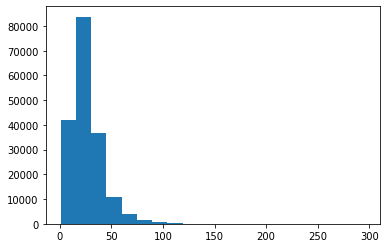

In [32]:
#distribution of data
import matplotlib.pyplot as plt
plt.hist(sent_len,bins=20)

In [33]:
#check the 95% percentile
output_seq_len =int(np.percentile(sent_len,95))
output_seq_len

55

In [34]:
#max length of the dataset
max(sent_len)

296

##Create Text Vectorizor Layer

In [35]:
#number of tokens
max_tokens =68000

In [36]:
#create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer =TextVectorization(max_tokens=max_tokens,
                                   output_sequence_length=output_seq_len)


In [37]:
#adapt text vectorizer to trainning data
text_vectorizer.adapt(train_sentences)

In [38]:
#Test the text vectorizer on random senteneces
import random
target_sentence=random.choice(train_sentences)
print(f"Text :\n{target_sentence}")
print(f"\nLength of the sentence :{len(target_sentence.split())}")
print(f"\nVectorized Text :{text_vectorizer( [target_sentence])}")

Text :
there were no significant differences in bp , pwv , ai , icam-@ , adma or endothelin-@ between the interventions .

Length of the sentence :21

Vectorized Text :[[   61     9    33    37   102     5   664  4143  4050 13972  7950    16
   5847    30     2   265     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [39]:
#check the count of the words
rct_20k_text_vocab =text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:{len(rct_20k_text_vocab)}")
print(f"Most common of word in vocab:{rct_20k_text_vocab[:5]}")
print(f"Least common of word in vocab:{rct_20k_text_vocab[:-5]}")

Number of words in vocab:64841
Most common of word in vocab:['', '[UNK]', 'the', 'and', 'of']
Least common of word in vocab:['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were', 'was', 'for', 'patients', 'group', 'p', 'at', 'or', 'study', 'on', 'treatment', 'is', 'after', 'by', 'this', 'groups', 'as', 'an', 'from', 'that', 'randomized', 'between', 'not', 'trial', 'no', 'compared', 'control', 'be', 'significant', 'intervention', 'significantly', 'n', 'months', 'than', 'we', 'vs', 'rsb', 'lsb', 'clinical', 'placebo', 'baseline', 'ci', 'two', 'during', 'weeks', 'both', 'had', 'primary', 'mean', 'are', 'using', 'participants', 'there', 'all', 'time', 'years', 'pain', 'therapy', 'who', 'mg', 'more', 'effect', 'effects', 'but', 'risk', 'difference', 'outcomes', 'total', 'care', 'rate', 'efficacy', 'received', 'associated', 'higher', 'respectively', 'days', 'analysis', 'outcome', 'use', 'one', 'week', 'women', 'may', 'randomly', 'levels', 'followup', 'will', 'increased', 'health'

In [40]:
#get the config of the txt vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

##Create Custom Embedding 

In [41]:
#Create token embedding layer
token_embed =layers.Embedding(input_dim=len(rct_20k_text_vocab),
                              output_dim=128,
                              mask_zero=True,
                              name="token_embedding")


In [42]:
#show the exmaple
print(f"Sentenc before vectorization :\n{target_sentence}\n")
vectorized_sentence=text_vectorizer([target_sentence])
print(f"sentence after vectorization(before embedding) :\n {vectorized_sentence}")
embedded_sentence =token_embed(vectorized_sentence)

print(f"Sentence after embedding\n{embedded_sentence}\n")
print(f"Sentence shape:{embedded_sentence.shape}")


Sentenc before vectorization :
there were no significant differences in bp , pwv , ai , icam-@ , adma or endothelin-@ between the interventions .

sentence after vectorization(before embedding) :
 [[   61     9    33    37   102     5   664  4143  4050 13972  7950    16
   5847    30     2   265     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding
[[[ 0.04267308  0.00176538 -0.01378962 ... -0.00862426  0.01789587
   -0.00223224]
  [ 0.04828098 -0.02517732  0.00154537 ... -0.04580836 -0.00596227
    0.04928246]
  [-0.0153937   0.00838218  0.02944065 ... -0.03064743  0.00636341
   -0.01998924]
  ...
  [ 0.02904639  0.02478418 -0.00610316 ...  0.04281298  0.03058468
    0.03786978]
  [ 0.02904639  0.02478418 -0.00610316 ...  0.04281298  0.03058468
    0.03786978]
  [ 0.02904639 

##Creating datasets with fast data loading

In [43]:
#turn the data into tensorflow datasets
train_dataset =tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset =tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset =tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [44]:
train_labels_one_hot.shape[0]


180040

In [45]:
#take tensorslice datasets and prefetch 
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

##Model 1 -CONV1D with token embedding

In [46]:
#create conv model to process sequences
inputs =layers.Input(shape=(1,),dtype=tf.string)
text_vectors =text_vectorizer(inputs)
token_embeddings =token_embed(text_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_1=tf.keras.Model(inputs,outputs)

#compile 
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [47]:
#model summary
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [48]:
#fit the model
history_model_1 =model_1.fit(train_dataset,
                             steps_per_epoch=int(0.1*len(train_dataset)),
                             epochs=3,
                             validation_data=valid_dataset,
                             validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 36s 8ms/step - loss: 0.9214 - accuracy: 0.6377 - val_loss: 0.6772 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6486 - accuracy: 0.7623 - val_loss: 0.6210 - val_accuracy: 0.7773
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6094 - accuracy: 0.7788 - val_loss: 0.5919 - val_accuracy: 0.7852


In [49]:
#evaluate the model
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5922 - accuracy: 0.7891


[0.5921768546104431, 0.78912353515625]

In [50]:
#make predcitons
model_1_pred_probs =model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

(array([[4.7831249e-01, 1.2147816e-01, 6.7205235e-02, 3.0505383e-01,
         2.7950253e-02],
        [4.1325554e-01, 2.9982978e-01, 1.5875973e-02, 2.6199788e-01,
         9.0409201e-03],
        [1.4139895e-01, 6.0581765e-03, 1.8020630e-03, 8.5071295e-01,
         2.7815368e-05],
        ...,
        [9.7287339e-06, 4.6740257e-04, 5.6874420e-04, 5.0071876e-06,
         9.9894911e-01],
        [4.3745402e-02, 4.4596478e-01, 1.0502382e-01, 5.5693798e-02,
         3.4957218e-01],
        [1.3197468e-01, 7.4254596e-01, 3.8474653e-02, 3.8883515e-02,
         4.8121195e-02]], dtype=float32), (30212, 5))

In [51]:
#convert pred prbs into classes
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [52]:
class_names


array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [53]:
#calcuate the results
model_1_results =calculate_results(y_true=val_label_encoded,
                                   y_pred=model_1_preds)
model_1_results


{'accuracy': 78.91235270753343,
 'f1': 0.7866335895674506,
 'precision': 0.7859214787685281,
 'recall': 0.7891235270753343}

In [54]:
baseline_results


{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

##Model 2 -Feature Extarction with pretrained token embeddings

In [55]:
MODEL_URL ="https://tfhub.dev/google/universal-sentence-encoder/4"


In [56]:
#downoad the model
import tensorflow_hub as hub
tf_hub_embedding_layer=hub.KerasLayer(MODEL_URL,
                                      trainable=False,
                                      name="universal_sentence_encoder")

In [57]:
#test the model
random_train_sentence=random.choice(train_sentences)
print(f"Random sentence :\n{random_train_sentence}")

use_embedded_sentence=tf_hub_embedding_layer([random_train_sentence])
print(f"embedded sentence :\n{use_embedded_sentence[0][:30]}")
print(f"length of the sentence :\n{len(use_embedded_sentence[0])}")


Random sentence :
the proportion of patients with improvement in cgi-s scale was @ % and @ % at the end of @ and @ months , respectively .
embedded sentence :
[-0.01737655  0.02619667 -0.06934702  0.00485474  0.02119379  0.01490964
 -0.01250265  0.04607086  0.04365773  0.06893639  0.07945712 -0.00084702
 -0.03297856  0.06835987 -0.01230108  0.02348799 -0.09638186 -0.04884323
  0.01660675 -0.01055725  0.04898286  0.00593884 -0.04964455 -0.02597403
  0.00261068  0.07027915  0.08255374  0.05417057 -0.01804327  0.0527127 ]
length of the sentence :
512


##Builing the NLP Feature extraction model

In [58]:
#define the model
inputs=layers.Input(shape=[],dtype=tf.string)
pretrained_embedding =tf_hub_embedding_layer(inputs)
x=layers.Dense(128,activation="relu")(pretrained_embedding)

outputs=layers.Dense(num_classes,activation="softmax")(x)
model_2 =tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name="model_2_USE_Feature_Extarctor")


#compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [59]:
#model_summary
model_2.summary()


Model: "model_2_USE_Feature_Extarctor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [60]:
#fit the model
history_model_2 =model_2.fit(train_dataset,
                             steps_per_epoch=int(0.1*len(train_dataset)),
                             epochs=3,
                             validation_data=valid_dataset,
                             validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9238 - accuracy: 0.6431 - val_loss: 0.7974 - val_accuracy: 0.6845
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7676 - accuracy: 0.7026 - val_loss: 0.7548 - val_accuracy: 0.7081
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7514 - accuracy: 0.7139 - val_loss: 0.7386 - val_accuracy: 0.7121


In [61]:
#evalaute the model
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.7400 - accuracy: 0.7137


[0.740041196346283, 0.7136568427085876]

In [62]:
#make predcitons
model_2_pred_probs =model_2.predict(valid_dataset)
model_2_pred_probs,model_2_pred_probs.shape

(array([[0.42393664, 0.3789853 , 0.0017208 , 0.1888439 , 0.00651331],
        [0.3236763 , 0.50753736, 0.00253676, 0.16369717, 0.00255244],
        [0.25526232, 0.12823035, 0.01797485, 0.5636803 , 0.03485224],
        ...,
        [0.00197436, 0.00439629, 0.05032589, 0.001011  , 0.94229245],
        [0.00409268, 0.05178219, 0.20470202, 0.00162296, 0.7378001 ],
        [0.15605089, 0.26896736, 0.50361353, 0.00720025, 0.06416804]],
       dtype=float32), (30212, 5))

In [63]:
#convert pred prbs into classes
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [64]:
#calcuate the results
model_2_results =calculate_results(y_true=val_label_encoded,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 71.36568251026083,
 'f1': 0.7106535109558985,
 'precision': 0.7136525773920339,
 'recall': 0.7136568251026082}

In [65]:
baseline_results


{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

##Model 3 -CONV1D with chractoer embedding

In [66]:
text_vectorizer,token_embed

(<keras.layers.preprocessing.text_vectorization.TextVectorization at 0x7ffad2847390>,
 <keras.layers.embeddings.Embedding at 0x7ffa8671ced0>)

##Create charactor level tokenizer

In [67]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [68]:
#make funciton to split into charactores
def split_chars(text):
  return " ".join(list(text))

#text splitting non-chractor level sequence into charactors
split_chars(random_train_sentence)


't h e   p r o p o r t i o n   o f   p a t i e n t s   w i t h   i m p r o v e m e n t   i n   c g i - s   s c a l e   w a s   @   %   a n d   @   %   a t   t h e   e n d   o f   @   a n d   @   m o n t h s   ,   r e s p e c t i v e l y   .'

In [69]:
" ".join(list(train_sentences[:5]))

'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) . a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks . outcome measures included pain reduction and improvement in function scores and systemic inflammation markers . pain was assessed using the visual analog pain scale ( @-@ mm ) . secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .'

In [70]:
#split sequence level data spits into chracter level data splits
train_chars =[split_chars(sentence) for sentence in train_sentences]
val_chars =[split_chars(sentence) for sentence in val_sentences]
test_chars =[split_chars(sentence) for sentence in test_sentences]

(train_chars[:5])

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [71]:
#avarage character length
char_lens =[len(sentence) for sentence in train_sentences]
mean_char_len =np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

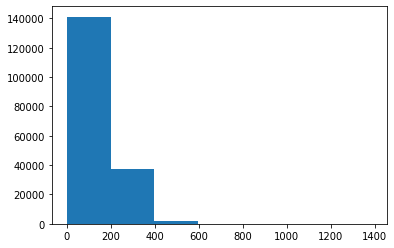

In [72]:
#check the distribution at sequence level
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7)

In [73]:
#find the charactor length covers of the sequences
output_seq_char_len =int(np.percentile(char_lens,95))
output_seq_char_len

290

In [74]:
#get all keyboard charactors
import string
alphabet =string.ascii_lowercase +string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [75]:
#create char-level token vectorizer instance
NUM_CHAR_TOKENS=len(alphabet) +2 #add 2 for space and unknown
char_vectorizer =TextVectorization(max_tokens =NUM_CHAR_TOKENS,
                                   output_sequence_length=output_seq_char_len,
                                   name="char_vectorizer")


In [76]:
#get all keyboard charactors
random.choice(train_sentences)

'of the @ pgs patients in the control group and acupoint injection group , @ and @ were cured , @ and @ were significantly improved , @ and @ were improved , @ and @ failed , with the effective rates being @ % and @ % , respectively .'

In [77]:
#adapt charactor vectorizer to training charactoer
char_vectorizer.adapt(train_chars)

In [78]:
#check char vocab stats
char_vocab =char_vectorizer.get_vocabulary()
print(f"Number of differenet charactors in char vocab :{len(char_vocab)}")
print(f"Most common charactoers :{char_vocab[:5]} ")
print(f"Least common charactoers :{char_vocab[-5:]} ")

Number of differenet charactors in char vocab :28
Most common charactoers :['', '[UNK]', 'e', 't', 'i'] 
Least common charactoers :['k', 'x', 'z', 'q', 'j'] 


In [79]:
#test out character vectorizer
random_train_chars =random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nlength of random train chars:\n {len(random_train_chars.split())}")
vectorized_chars=char_vectorizer([random_train_chars])
print(f"\nvectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars:\n {len(vectorized_chars[0])}")


Charified text:
 a f t e r   a d j u s t m e n t   f o r   m u l t i p l e   t e s t i n g   ,   o n l y   d e c l i n e s   i n   s c d @   r e m a i n e d   s i g n i f i c a n t   .

length of random train chars:
 72

vectorized chars:
 [[ 5 17  3  2  8  5 10 27 16  9  3 15  2  6  3 17  7  8 15 16 12  3  4 14
  12  2  3  2  9  3  4  6 18  7  6 12 19 10  2 11 12  4  6  2  9  4  6  9
  11 10  8  2 15  5  4  6  2 10  9  4 18  6  4 17  4 11  5  6  3  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0 

##Creating Character Level Embedding


In [80]:
#craete embeddiing layer
char_embed=layers.Embedding(input_dim=len(char_vocab),
                            output_dim=25,
                            mask_zero=True,
                            name="char_embed")

In [81]:
#test the character embedding layer
print(f"Charified text :\n {random_train_chars}\n ")
char_embed_example =char_embed(char_vectorizer([random_train_chars]))

print(f"Embedded chars (after vectorization and embedding) :\n {char_embed_example}\n")
print(f"Character embedding shape :{char_embed_example.shape}")


Charified text :
 a f t e r   a d j u s t m e n t   f o r   m u l t i p l e   t e s t i n g   ,   o n l y   d e c l i n e s   i n   s c d @   r e m a i n e d   s i g n i f i c a n t   .
 
Embedded chars (after vectorization and embedding) :
 [[[-0.02617861  0.02129631  0.04007376 ... -0.04726722 -0.04776038
    0.0170255 ]
  [-0.01897519  0.02056113 -0.02632288 ... -0.04880185 -0.04135145
    0.01532734]
  [ 0.01808978  0.0310585   0.00903457 ...  0.00321486  0.00242727
   -0.00147019]
  ...
  [ 0.04729942 -0.03779763  0.04865481 ...  0.02853996 -0.04245511
   -0.02508305]
  [ 0.04729942 -0.03779763  0.04865481 ...  0.02853996 -0.04245511
   -0.02508305]
  [ 0.04729942 -0.03779763  0.04865481 ...  0.02853996 -0.04245511
   -0.02508305]]]

Character embedding shape :(1, 290, 25)


In [82]:
MODEL_URL ="https://tfhub.dev/google/universal-sentence-encoder/4"

#downoad the model
import tensorflow_hub as hub
tf_hub_embedding_layer=hub.KerasLayer(MODEL_URL,
                                      trainable=False,
                                      name="universal_sentence_encoder_character_embedding")

#define the model
inputs=layers.Input(shape=[],dtype=tf.string)
pretrained_embedding =tf_hub_embedding_layer(inputs)
x=layers.Dense(128,activation="relu")(pretrained_embedding)

outputs=layers.Dense(num_classes,activation="softmax")(x)
model_3 =tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name="model_3_USE_Feature_Extarctor_charactor_embedding")


#compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])




In [83]:
#Model Summery
model_3.summary()

Model: "model_3_USE_Feature_Extarctor_charactor_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder_c (None, 512)               256797824 
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


##Building CONV1D Model to fit character Embedding

In [84]:
#make conv1d on chars
inputs =layers.Input(shape=(1,),dtype ="string")
char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(char_embeddings)
x=layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_3 =tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name="model_3_conv1d_char_embedding")

#compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [85]:
#Model Summery
model_3.summary()

Model: "model_3_conv1d_char_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
___________________________________

In [86]:
#turn the data into tensorflow datasets
train_char_dataset =tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot))
valid_char_dataset =tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot))
test_char_dataset =tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot))

#take tensorslice datasets and prefetch 
train_char_dataset=train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset=valid_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [87]:
#fit the model
history_model_3 =model_3.fit(train_char_dataset,
                             steps_per_epoch=int(0.1*len(train_char_dataset)),
                             epochs=3,
                             validation_data=valid_char_dataset,
                             validation_steps=int(0.1*len(valid_char_dataset)))

Epoch 1/3
562/562 [==============================] - 3s 5ms/step - loss: 1.2832 - accuracy: 0.4828 - val_loss: 1.0457 - val_accuracy: 0.5967
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9964 - accuracy: 0.6041 - val_loss: 0.9241 - val_accuracy: 0.6423
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9126 - accuracy: 0.6437 - val_loss: 0.8569 - val_accuracy: 0.6686


In [88]:
#evalaute the model
model_3.evaluate(valid_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8743 - accuracy: 0.6628


[0.8742945194244385, 0.6628161072731018]

In [89]:
#make predcitons
model_3_pred_probs =model_3.predict(valid_char_dataset)
model_3_pred_probs,model_3_pred_probs.shape

(array([[0.20391665, 0.34310326, 0.1092646 , 0.3133143 , 0.03040118],
        [0.18376851, 0.60727394, 0.02125054, 0.11640632, 0.07130072],
        [0.17019439, 0.11809579, 0.31009448, 0.28794473, 0.11367069],
        ...,
        [0.01850111, 0.02149775, 0.20120536, 0.02054187, 0.7382539 ],
        [0.04208677, 0.16160867, 0.28351614, 0.09143937, 0.42134905],
        [0.35636795, 0.51363313, 0.051967  , 0.06868161, 0.0093503 ]],
       dtype=float32), (30212, 5))

In [90]:
#convert pred prbs into classes
model_3_preds=tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 1])>

In [91]:
#calcuate the results
model_3_results =calculate_results(y_true=val_label_encoded,
                                   y_pred=model_3_preds)
model_3_results

{'accuracy': 66.28160995630876,
 'f1': 0.6551656445644067,
 'precision': 0.6528964622209735,
 'recall': 0.6628160995630875}

In [92]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

##Model 4 - Combining pretrained token embedding + chracers embeddings

1.create a token level embedding model

2.create a chracter level emebedding

3.combine 1 and 2 model with concatanete layer

4.build a series of output layers

5.constsuct a mdoel which taken token and character and provide the output

In [106]:

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [108]:
#get the model summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder_char (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

In [110]:
pip install keras.utils


  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=2e3470232d2bdd12a07dd7a1830d74928b3fcc2758c6ed597221d9aa3c5c3b0c
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


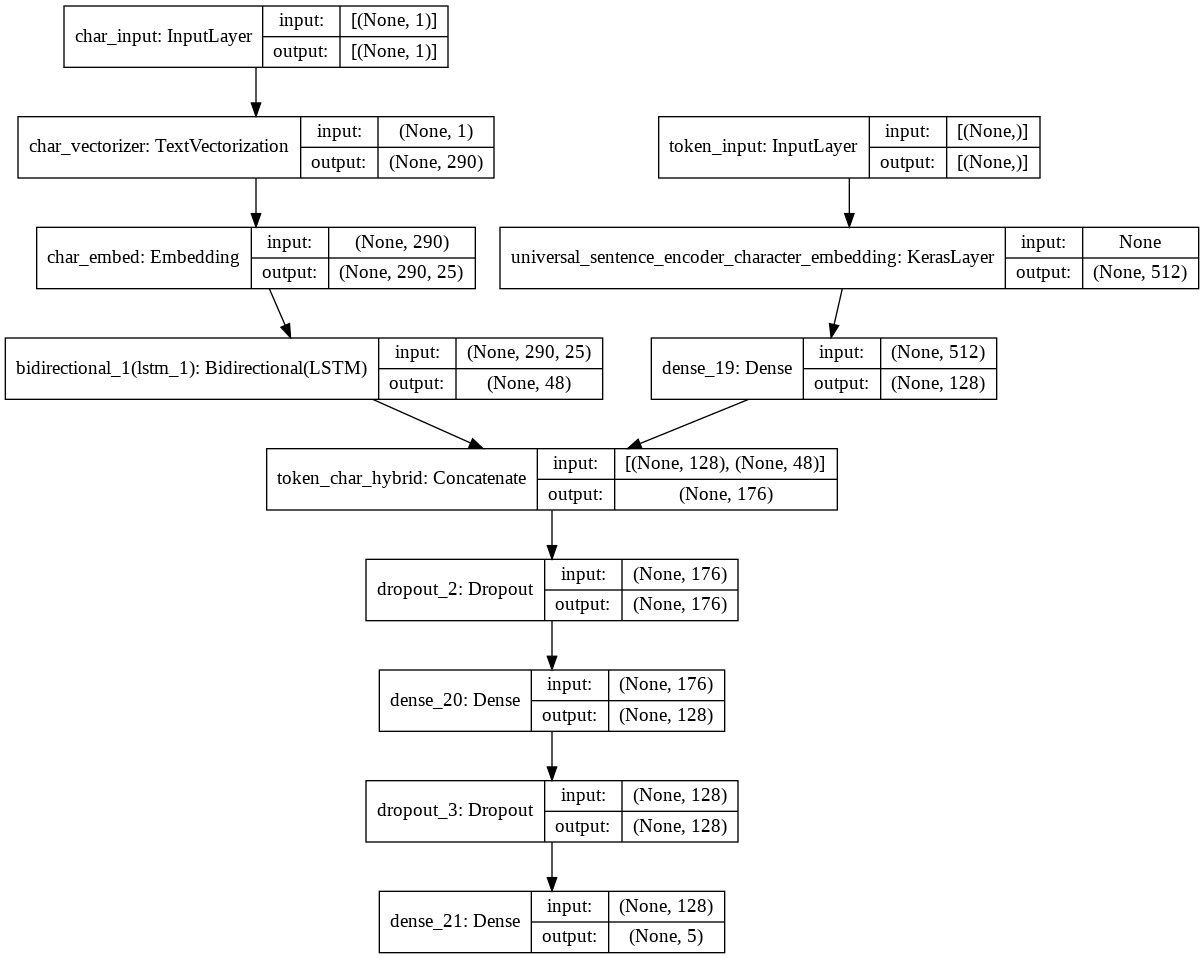

In [113]:
#plot hybrid token and character model
from keras.utils.vis_utils import plot_model
plot_model(model_4,show_shapes=True)

In [114]:
#compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


##Combine the dataset for fast loading

In [120]:
#combine char and token into dataset
train_char_token_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset=tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

train_char_token_dataset

#prefetch and batch train data
train_char_token_dataset =train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [121]:
#Validation data
#combine char and token into dataset
val_char_token_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset=tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))

#prefetch and batch train data
val_char_token_dataset =val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#combine char and token into dataset
test_char_token_data=tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_char_token_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset=tf.data.Dataset.zip((test_char_token_data,test_char_token_labels))


#prefetch and batch train data
test_char_token_dataset =test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [122]:
#check out datasets
train_char_token_dataset,val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [124]:
#fit the model
history_model_4 =model_4.fit(train_char_token_dataset,
                             steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                             epochs=3,
                             validation_data=val_char_token_dataset,
                             validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 37s 49ms/step - loss: 0.9892 - accuracy: 0.6036 - val_loss: 0.7838 - val_accuracy: 0.6955
Epoch 2/3
562/562 [==============================] - 25s 45ms/step - loss: 0.8057 - accuracy: 0.6903 - val_loss: 0.7150 - val_accuracy: 0.7231
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.7730 - accuracy: 0.7045 - val_loss: 0.6884 - val_accuracy: 0.7400


In [125]:
#evalaute the model
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6904 - accuracy: 0.7378


[0.69035404920578, 0.7378194332122803]

In [126]:
#make predcitons
model_4_pred_probs =model_4.predict(val_char_token_dataset)
model_4_pred_probs,model_4_pred_probs.shape

(array([[4.5053837e-01, 3.5565087e-01, 3.2152464e-03, 1.8396182e-01,
         6.6337050e-03],
        [3.3569100e-01, 5.1579702e-01, 3.2753923e-03, 1.4320746e-01,
         2.0291228e-03],
        [3.1320840e-01, 1.9169316e-01, 9.2367686e-02, 3.2938179e-01,
         7.3348865e-02],
        ...,
        [5.7886785e-04, 9.0146577e-03, 5.0813805e-02, 1.9763077e-04,
         9.3939507e-01],
        [6.0511655e-03, 6.7276120e-02, 2.0868076e-01, 3.7718355e-03,
         7.1422011e-01],
        [3.5600439e-01, 3.4445900e-01, 2.2379875e-01, 4.2472214e-02,
         3.3265684e-02]], dtype=float32), (30212, 5))

In [127]:
#convert pred prbs into classes
model_4_preds=tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [128]:
#calcuate the results
model_4_results =calculate_results(y_true=val_label_encoded,
                                   y_pred=model_4_preds)
model_4_results

{'accuracy': 73.78194095061565,
 'f1': 0.7358417292933591,
 'precision': 0.7375422040217056,
 'recall': 0.7378194095061565}

In [129]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

#Model 5 :Transfer Learning with charactor embedding